In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import re
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm

In [3]:
tqdm()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [2]:
def preprocess(text):
    text = text.lower() #to lowercase
    corpus = re.split('\.|\?|!', text) #split sentence
    word_to_id = {}
    id_to_word = {}

    word_to_id["<end or start of sentnece>"] = 0
    id_to_word[0] = "<end or start of sentnece>"

    for sentence in corpus:
        sentence = sentence.split()
        for word in sentence: #create word_to_id and id_to_word
            if word not in word_to_id:
                id = len(word_to_id)
                word_to_id[word] = id
                id_to_word[id] = word

    for i in range(len(corpus)): #create corpus
        corpus[i] = [word_to_id[word] for word in corpus[i].split()]

    return corpus, word_to_id, id_to_word #corpus is list of list, one list represent one sentence

def create_context_target(sentence:list, WINDOW_SIZE:int): #example input [5,1,2,4,6]
    target = sentence.copy()
    contexts = []
    for word_index, word in enumerate(sentence):
        context = []
        WINDOW = sentence[max(word_index-WINDOW_SIZE,0) : min(word_index+WINDOW_SIZE+1, len(sentence))]

        #assuming word index is at 3, WINDOW_SIZE is 1, then 234 is selected
        for context_word in WINDOW:
            if context_word != word:
                context.append(context_word)
        if len(context) != 2*WINDOW_SIZE+1 :
            for i in range((2*WINDOW_SIZE) - len(context)):
                context.append(0)
        contexts.append(context)

    return contexts, target


In [ ]:
class UnigramSampler:
    def __init__(self, corpus:list, power:float, sample_size:int):
        self.sample_size = sample_size #negative sample size
        self.vocab_size = None
        self.word_p = None

        corpus = [word for sentence in corpus for word in sentence]

        count = Counter() #count word in corpus
        for word_id in corpus:
            count[word_id] += 1

        self.vocab_size = len(count)+1
        self.word_p = np.zeros(self.vocab_size)

        for i in range(self.vocab_size):
            self.word_p[i] = count[i] #frequency for each word

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target:torch.tensor):
        batch_size = target.shape[0]
        target = target.cpu().clone().numpy()
        negative_sample = np.zeros((batch_size, self.sample_size),dtype=np.float32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i,:] = np.random.choice(self.vocab_size, self.sample_size, replace=False, p=p)
        return torch.tensor(negative_sample,dtype=torch.int32)


In [ ]:
class CorpusDataset(Dataset):
    def __init__(self, WINDOW_SIZE=1):
        super().__init__()
        with open("ptb.train.txt","r") as file:
            corpus_raw = file.read()
        self.corpus, self.word_to_id, self.id_to_word = preprocess(corpus_raw)
        X = []
        y = []
        for sentence in self.corpus:
            contexts, target = create_context_target(sentence, WINDOW_SIZE=1)
            X += contexts
            y += target
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)



    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

    def get_corpus(self):
        return self.corpus

    def get_vocab_size(self):
        return len(self.word_to_id)


In [5]:
# vocab_size = len(word_to_id)
# torch.manual_seed(8)
# embedding1 = nn.Embedding(vocab_size, 100)
# embedding2 = nn.Embedding(vocab_size, 100)
# x1 = torch.tensor(X[:100])
# y1 = torch.tensor(y[:100])
# hidden = embedding1(x1)
# hidden_neuron = hidden.sum(axis=1)

# target_W = embedding2(y1)


# summ = torch.sum((hidden_neuron[0] * target_W[0]))

# sigmoid = nn.Sigmoid()
# loss = nn.BCELoss()

# prob = sigmoid(summ)
# print(loss(prob, torch.tensor(1,dtype=torch.float32)).item())
# bce_loss = nn.BCEWithLogitsLoss()
# print(bce_loss(summ,torch.tensor(1,dtype=torch.float32)).item())

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self,vocab_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
    def forward(self, h, idx):
        target_W = self.embedding(idx)
        out = torch.sum(target_W*h,axis=1)

        return out

class CBOW(nn.Module):
    def __init__(self, corpus, vocab_size, embed_dim, negative_sample_size = 5):
        super().__init__()
        self.negative_sample_size = negative_sample_size
        self.embedding_in = nn.Embedding(vocab_size, embed_dim)
        self.embed_dot  = EmbeddingDot(vocab_size, embed_dim)
        self.sampler = UnigramSampler(corpus, power=0.75, sample_size=self.negative_sample_size)


    def forward(self, contexts:torch.tensor, target:torch.tensor, negative_sample):
        out = {"correct":[], "negative":[]}

        h = self.embedding_in(contexts)
        window_size = h.shape[1]
        h = h.sum(axis=1)
        h *= 1/window_size
        correct_out = self.embed_dot(h, target)
        out["correct"].append(correct_out)

        negative_sample_size = negative_sample.shape[1]

        for i in range(negative_sample_size):
            negative_out = self.embed_dot(h, negative_sample[:,i])
            out["negative"].append(negative_out)

        return out







In [7]:
dataset = CorpusDataset()
print(len(dataset))

890163


In [ ]:
epochs = 100
learning_rate = 0.001
negative_sample_size = 5
device = torch.device("cuda")
dataset = CorpusDataset()
dataloader = DataLoader(dataset=dataset, batch_size=128, drop_last=True, shuffle=True)

epoch_bar = tqdm(desc="epoch_bar", total=epochs, position=0)
train_bar= tqdm(desc="train_bar", total=len(dataloader), position=1)

vocab_size = dataset.get_vocab_size()
corpus = dataset.get_corpus()
sampler = UnigramSampler(corpus, power=0.75, sample_size=negative_sample_size)
model = CBOW(corpus, vocab_size, embed_dim=100, negative_sample_size=negative_sample_size).to(device)

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

epoch_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for contexts, target in dataloader:
        contexts = contexts.to(device)
        target = target.to(device)
        negative_sample = sampler.get_negative_sample(target).to(device)
        out = model(contexts,target, negative_sample)

        correct_label = torch.ones(128).to(device)
        final_loss = loss(out['correct'][0],correct_label)

        negative_label = torch.zeros(128).to(device)
        for i in range(negative_sample_size):
            final_loss += loss(out['negative'][i], negative_label)

        final_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_bar.update()
        train_bar.set_postfix(loss=final_loss.item())

        running_loss += final_loss.item()
    running_loss = running_loss / len(dataloader)
    epoch_loss.append(running_loss)

    train_bar.n = 0
    epoch_bar.update()



epoch_bar:   0%|          | 0/100 [00:00<?, ?it/s]

train_bar:   0%|          | 0/6954 [00:00<?, ?it/s]

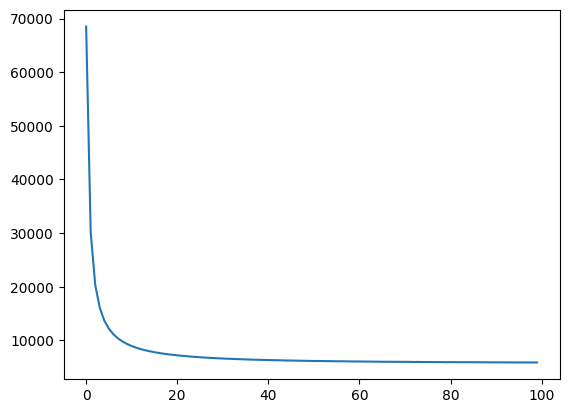

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(100),epoch_loss)